In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from PIL import Image

In [4]:
images_dir = Path("/kaggle/input/ph2-resized/trainx")
masks_dir = Path("/kaggle/input/ph2-resized/trainy")

In [5]:
images = sorted(list(map(str, list(images_dir.glob("*.bmp")))))
masks = sorted(list(map(str, list(masks_dir.glob("*.bmp")))))

In [6]:
X = np.array([np.array(Image.open(fname)) for fname in images])
Y = np.array([np.array(Image.open(fname)) for fname in masks])

In [7]:
import matplotlib.pyplot as plt

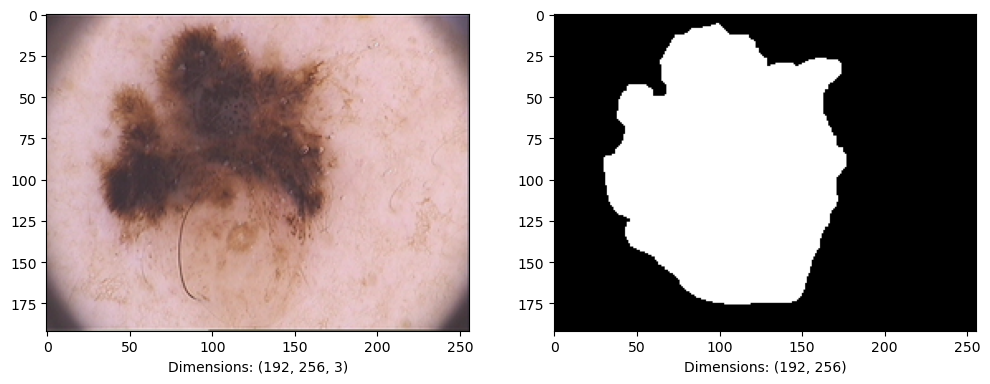

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(X[15])
plt.xlabel("Dimensions: "+str(np.array(X[50]).shape))
plt.subplot(1,2,2)
plt.imshow(Y[15], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y[50]).shape))
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [11]:
len(x_train), len(x_test)

(160, 40)

In [10]:
del X, Y

In [11]:
import cv2
from copy import deepcopy
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

def vertical_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 0)
    y_image = cv2.flip(y_image.astype('float32'), 0)
    return x_image, y_image.astype('int')

def img_augmentation(x, y, cycles):
    x_buffer = deepcopy(x)
    y_buffer = deepcopy(y)
    
    x_rotat = []
    y_rotat = []
    x_flip_h = []
    y_flip_h = []
    x_flip_v = []
    y_flip_v = []
    for cycle in range(cycles):
        for idx in range(len(x_buffer)):
            x,y = random_rotation(x_buffer[idx], y_buffer[idx])
            x_rotat.append(x)
            y_rotat.append(y)
        
            x,y = horizontal_flip(x_buffer[idx], y_buffer[idx])
            x_flip_h.append(x)
            y_flip_h.append(y)
        
            x,y = vertical_flip(x_buffer[idx], y_buffer[idx])
            x_flip_v.append(x)
            y_flip_v.append(y)
        x_aug = np.concatenate([x_rotat, x_flip_h, x_flip_v])
        y_aug = np.concatenate([y_rotat, y_flip_h, y_flip_v])
        
        del x_rotat, x_flip_h, x_flip_v, y_rotat, y_flip_h, y_flip_v
        x_rotat = []
        y_rotat = []
        x_flip_h = []
        y_flip_h = []
        x_flip_v = []
        y_flip_v = []
        
        del x_buffer, y_buffer
        x_buffer = x_aug
        y_buffer = y_aug
    
    return x_buffer, y_buffer

In [12]:
x_train_aug, y_train_aug = img_augmentation(x_train, y_train, 3)
x_train_full = np.concatenate([x_train, x_train_aug])
del x_train_aug, x_train
y_train_full = np.concatenate([y_train, y_train_aug])
del y_train_aug, y_train

x_test_aug, y_test_aug = img_augmentation(x_test, y_test, 3)
x_test_full = np.concatenate([x_test, x_test_aug])
del x_test_aug, x_test
y_test_full = np.concatenate([y_test, y_test_aug])
del y_test_aug, y_test

In [15]:
len(x_train_full), len(x_test_full)

(4480, 1120)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.20)
del x_train_full, y_train_full

In [17]:
len(x_train), len(x_val)

(3584, 896)

In [14]:
from keras import backend as K
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac



def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision



def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [15]:
from tensorflow.keras import layers
class ConvUnit(layers.Layer):
    def __init__(self,filters, kernel_size, activation, transpose=False, **kwargs):
        super().__init__(**kwargs)
        
        if transpose:
            self.conv = layers.Conv2DTranspose(filters, kernel_size, padding='same')
        else:
            self.conv = layers.Conv2D(filters, kernel_size, padding='same')

        self.bn = layers.BatchNormalization()
        self.activation = layers.Activation(activation)
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activation(x)
        return x

class ConvBlock(layers.Layer):
    def __init__(self, num_conv_unit, filters, kernel_size, activation, **kwargs):
        super().__init__(**kwargs)
        self.conv_units = [ConvUnit(filters, kernel_size, activation) for _ in range(num_conv_unit)]
        self.pool = layers.MaxPool2D()
        
    def call(self, inputs):
        x = inputs
        for conv_unit in self.conv_units:
            x = conv_unit(x)
        x = self.pool(x)
        return x

class UpSamplingConvTBlock(layers.Layer):
    def __init__(self, num_conv_unit, filters, kernel_size, activation, **kwargs):
        super().__init__(**kwargs)
        self.up_sampling = layers.UpSampling2D()
        self.conv_units = [ConvUnit(filters, kernel_size, activation, transpose=True) for _ in range(num_conv_unit)]
        
    def call(self, inputs):
        x = inputs
        x = self.up_sampling(x)
        for conv_unit in self.conv_units:
            x = conv_unit(x)
        return x

In [16]:
def SegNet(activation="relu"):
    inputs = keras.Input(shape=(192, 256, 3))
    
    x = ConvBlock(num_conv_unit=2,
                  filters=64,
                  kernel_size=(3,3),
                  activation=activation)(inputs)
    #x = layers.Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(inputs)
    #x = layers.BatchNormalization(name='bn1')(x)
    #x = layers.Activation('relu')(x)
    #x = layers.Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    #x = layers.BatchNormalization(name='bn2')(x)
    #x = layers.Activation('relu')(x)
    #x = layers.MaxPooling2D()(x)
    
    x = ConvBlock(num_conv_unit=2,
                  filters=128,
                  kernel_size=(3,3),
                  activation=activation)(x)
    
    x = ConvBlock(num_conv_unit=3,
                  filters=256,
                  kernel_size=(3,3),
                  activation=activation)(x)
    
    x = ConvBlock(num_conv_unit=3,
                  filters=512,
                  kernel_size=(3,3),
                  activation=activation)(x)
    
    x = ConvBlock(num_conv_unit=3,
                  filters=512,
                  kernel_size=(3,3),
                  activation=activation)(x)
    
    x = layers.Dense(1024, activation=activation)(x)
    x = layers.Dense(1024, activation=activation)(x)
    
    x = UpSamplingConvTBlock(num_conv_unit=3,
                             filters=512,
                             kernel_size=(3,3),
                             activation=activation)(x)
    
    x = UpSamplingConvTBlock(num_conv_unit=2,
                             filters=512,
                             kernel_size=(3,3),
                             activation=activation)(x)
    x = ConvUnit(filters=256,
                 kernel_size=(3,3),
                 activation=activation,
                 transpose=True)(x)
    
    x = UpSamplingConvTBlock(num_conv_unit=2,
                             filters=256,
                             kernel_size=(3,3),
                             activation=activation)(x)
    x = ConvUnit(filters=128,
                 kernel_size=(3,3),
                 activation=activation,
                 transpose=True)(x)
    
    x = UpSamplingConvTBlock(num_conv_unit=1,
                             filters=128,
                             kernel_size=(3,3),
                             activation=activation)(x)
    x = ConvUnit(filters=64,
                 kernel_size=(3,3),
                 activation=activation,
                 transpose=True)(x)
    
    x = UpSamplingConvTBlock(num_conv_unit=1,
                             filters=64,
                             kernel_size=(3,3),
                             activation=activation)(x)
    x = ConvUnit(filters=1,
                 kernel_size=(3,3),
                 activation="sigmoid")(x)
    
    output = layers.Reshape((192, 256))(x)
    
    return keras.Model(inputs=inputs, outputs=output)

In [37]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    segnet_model = SegNet("LeakyReLU")

In [38]:
segnet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv_block (ConvBlock)      (None, 96, 128, 64)       39232     
                                                                 
 conv_block_1 (ConvBlock)    (None, 48, 64, 128)       222464    
                                                                 
 conv_block_2 (ConvBlock)    (None, 24, 32, 256)       1478400   
                                                                 
 conv_block_3 (ConvBlock)    (None, 12, 16, 512)       5905920   
                                                                 
 conv_block_4 (ConvBlock)    (None, 6, 8, 512)         7085568   
                                                                 
 dense (Dense)               (None, 6, 8, 1024)        5253

In [39]:
segnet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[iou, dice_coef, precision, recall, accuracy])

In [40]:
hist = segnet_model.fit(x_train, y_train, epochs=25, batch_size=8, validation_data= (x_val, y_val))

2023-02-15 20:02:22.359047: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_297836"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:377"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 8
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

Epoch 1/25
448/448 [==============================] - ETA: 0s - loss: 0.4013 - iou: 0.8339 - dice_coef: 0.5867 - precision: 0.7865 - recall: 0.8707 - accuracy: 0.8784

2023-02-15 20:04:19.802554: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_314653"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:403"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 8
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

448/448 [==============================] - 128s 255ms/step - loss: 0.4013 - iou: 0.8339 - dice_coef: 0.5867 - precision: 0.7865 - recall: 0.8707 - accuracy: 0.8784 - val_loss: 0.4970 - val_iou: 0.7915 - val_dice_coef: 0.6230 - val_precision: 0.6024 - val_recall: 0.9146 - val_accuracy: 0.7963
Epoch 2/25
448/448 [==============================] - 109s 242ms/step - loss: 0.2851 - iou: 0.8942 - dice_coef: 0.6725 - precision: 0.8607 - recall: 0.9029 - accuracy: 0.9227 - val_loss: 0.2641 - val_iou: 0.9011 - val_dice_coef: 0.6857 - val_precision: 0.8459 - val_recall: 0.9000 - val_accuracy: 0.9199
Epoch 3/25
448/448 [==============================] - 108s 241ms/step - loss: 0.2187 - iou: 0.9255 - dice_coef: 0.7351 - precision: 0.9000 - recall: 0.9186 - accuracy: 0.9429 - val_loss: 0.2293 - val_iou: 0.9133 - val_dice_coef: 0.7490 - val_precision: 0.8185 - val_recall: 0.9298 - val_accuracy: 0.9149
Epoch 4/25
448/448 [==============================] - 109s 243ms/step - loss: 0.1901 - iou: 0.9366 

In [41]:
segnet_model.save_weights("segnet_25.hdf5")

In [17]:
class UDConvUnit(layers.Layer):
    def __init__(self,filters, kernel_size, dropout = 0.40, **kwargs):
        super().__init__(**kwargs)

        self.conv = layers.Conv2D(filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()
        self.activation = layers.Activation("LeakyReLU")
        
        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.activation2 = layers.Activation("LeakyReLU")

        self.dropout = layers.SpatialDropout2D(dropout)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation2(x)

        x = self.dropout(x)
        return x

In [18]:
from tensorflow.keras.layers import MaxPooling2D, concatenate, UpSampling2D
def UNet():
    dropout_val = 0.40
    inputs = keras.Input(shape=(192, 256, 3))
    
    x1 = UDConvUnit(filters=32,
                    kernel_size=(3,3))(inputs)
    p1 = MaxPooling2D(pool_size=(2, 2))(x1)

    x2 = UDConvUnit(filters=64,
                    kernel_size=(3,3))(p1)
    p2 = MaxPooling2D(pool_size=(2, 2))(x2)

    x3 = UDConvUnit(filters=128,
                    kernel_size=(3,3))(p2)
    p3 = MaxPooling2D(pool_size=(2, 2))(x3)

    x4 = UDConvUnit(filters=256,
                    kernel_size=(3,3))(p3)
    p4 = MaxPooling2D(pool_size=(2, 2))(x4)

    x5 = UDConvUnit(filters=512,
                    kernel_size=(3,3))(p4)
    p5 = MaxPooling2D(pool_size=(2, 2))(x5)

    x6 = UDConvUnit(filters=1024,
                    kernel_size=(3,3))(p5)

    u1 = concatenate([UpSampling2D(size=(2, 2))(x6), x5],
                    axis=3)
    ux1 = UDConvUnit(filters=512,
                    kernel_size=(3,3))(u1)

    u2 = concatenate([UpSampling2D(size=(2, 2))(ux1), x4],
                    axis=3)
    ux2 = UDConvUnit(filters=256,
                    kernel_size=(3,3))(u2)

    u3 = concatenate([UpSampling2D(size=(2, 2))(ux2), x3],
                    axis=3)
    ux3 = UDConvUnit(filters=128,
                    kernel_size=(3,3))(u3)

    u4 = concatenate([UpSampling2D(size=(2, 2))(ux3), x2],
                    axis=3)
    ux4 = UDConvUnit(filters=64,
                    kernel_size=(3,3))(u4)

    u5 = concatenate([UpSampling2D(size=(2, 2))(ux4), x1],
                    axis=3)
    ux5 = UDConvUnit(filters=32,
                    kernel_size=(3,3),
                    dropout = dropout_val)(u5)

    x_final =  ConvUnit(filters=1,
                       kernel_size=(1,1),
                       activation="sigmoid")(ux5)

    output = layers.Reshape((192, 256))(x_final)


    return keras.Model(inputs=inputs, outputs=output) 

In [27]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    unet_model = UNet()
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 ud_conv_unit_11 (UDConvUnit)   (None, 192, 256, 32  10400       ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 96, 128, 32)  0          ['ud_conv_unit_11[0][0]']        
                                                                                            

In [28]:
unet_model.compile(optimizer=keras.optimizers.Adam(0.003), loss= [jaccard_distance],metrics=[iou, dice_coef, precision, recall, accuracy] )

In [21]:
y_train = y_train.astype(float)
y_test_full = y_test_full.astype(float)
y_val = y_val.astype(float)

In [29]:
hist = unet_model.fit(x_train, y_train, epochs=25, batch_size=8, validation_data= (x_val, y_val))

2023-02-15 19:19:28.941351: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 704643072 exceeds 10% of free system memory.
2023-02-15 19:19:30.226066: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 704643072 exceeds 10% of free system memory.
2023-02-15 19:19:31.265569: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 704643072 exceeds 10% of free system memory.
2023-02-15 19:19:32.096077: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_i

Epoch 1/25
448/448 [==============================] - ETA: 0s - loss: 0.1369 - iou: 0.8631 - dice_coef: 0.6309 - precision: 0.8074 - recall: 0.8525 - accuracy: 0.8837

2023-02-15 19:21:02.474188: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_162482"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:113"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 8
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

448/448 [==============================] - 97s 181ms/step - loss: 0.1369 - iou: 0.8631 - dice_coef: 0.6309 - precision: 0.8074 - recall: 0.8525 - accuracy: 0.8837 - val_loss: 0.2558 - val_iou: 0.7442 - val_dice_coef: 0.6310 - val_precision: 0.4963 - val_recall: 0.9754 - val_accuracy: 0.6883
Epoch 2/25
448/448 [==============================] - 77s 172ms/step - loss: 0.0928 - iou: 0.9072 - dice_coef: 0.7243 - precision: 0.8759 - recall: 0.8487 - accuracy: 0.9096 - val_loss: 0.0758 - val_iou: 0.9242 - val_dice_coef: 0.7930 - val_precision: 0.8834 - val_recall: 0.8704 - val_accuracy: 0.9209
Epoch 3/25
448/448 [==============================] - 77s 171ms/step - loss: 0.0798 - iou: 0.9202 - dice_coef: 0.7670 - precision: 0.8952 - recall: 0.8582 - accuracy: 0.9195 - val_loss: 0.0570 - val_iou: 0.9430 - val_dice_coef: 0.8312 - val_precision: 0.9042 - val_recall: 0.9150 - val_accuracy: 0.9425
Epoch 4/25
448/448 [==============================] - 77s 171ms/step - loss: 0.0728 - iou: 0.9272 - di

In [30]:
unet_model.save_weights("unet_model_25.hdf5")

In [32]:
from plot_keras_history import plot_history

(<Figure size 2000x1000 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
         <AxesSubplot:title={'center':'Iou'}, xlabel='Epochs', ylabel='Iou'>,
         <AxesSubplot:title={'center':'Dice coef'}, xlabel='Epochs', ylabel='Dice coef'>,
         <AxesSubplot:title={'center':'Precision'}, xlabel='Epochs', ylabel='Precision'>],
        [<AxesSubplot:title={'center':'Recall'}, xlabel='Epochs', ylabel='Recall'>,
         <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

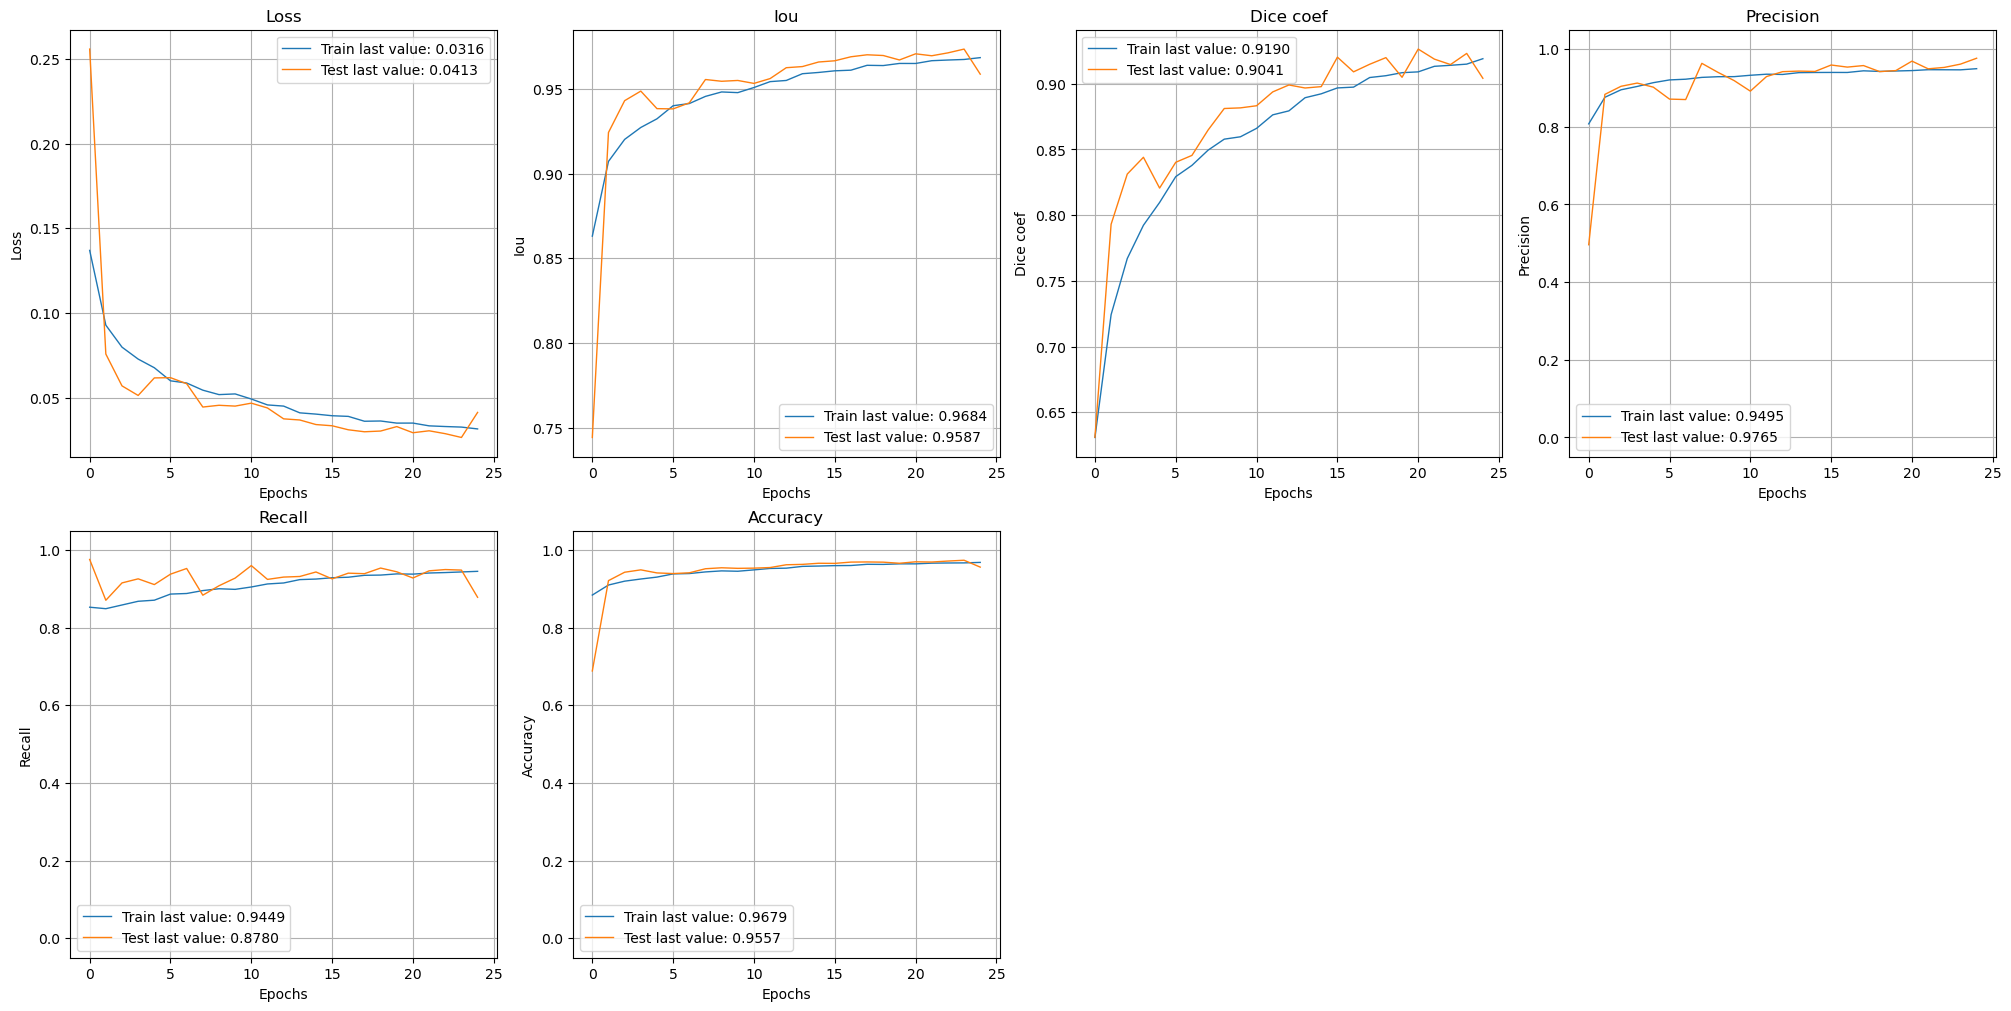

In [33]:
plot_history(hist)

In [22]:
segnet_model = SegNet("LeakyReLU")
segnet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[iou, dice_coef, precision, recall, accuracy])
segnet_model.load_weights("segnet_25.hdf5")

unet_model = UNet()
unet_model.compile(optimizer=keras.optimizers.Adam(0.003), loss= [jaccard_distance],metrics=[iou, dice_coef, precision, recall, accuracy] )
unet_model.load_weights("unet_model_25.hdf5")

In [23]:
print('\n~~~~~~~~~~~~~~~Stats after 25 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res_unet = segnet_model.evaluate(x_train, y_train, batch_size= 8)
res_segnet = unet_model.evaluate(x_train, y_train, batch_size= 8)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]*100, res_unet[0] * 100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res_unet = unet_model.evaluate(x_test_full, y_test_full, batch_size= 4)
res_segnet = segnet_model.evaluate(x_test_full, y_test_full, batch_size= 4)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]*100, res_unet[0] * 100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res_unet = unet_model.evaluate(x_val, y_val, batch_size= 4)
res_segnet = segnet_model.evaluate(x_val, y_val, batch_size= 4)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]*100, res_unet[0] * 100))
print('________________________')



~~~~~~~~~~~~~~~Stats after 25 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

448/448 [==============================] - 32s 65ms/step - loss: 0.0440 - iou: 0.9560 - dice_coef: 0.9015 - precision: 0.9803 - recall: 0.8688 - accuracy: 0.9518
_______________SegNet_____Unet____
IOU:       |   95.60  |   97.34  |
Dice Coef: |   90.15  |   93.89  |
Precision: |   98.03  |   94.81  |
Recall:    |   86.88  |   96.56  |
Accuracy:  |   95.18  |   97.25  |
Loss:      |   4.40  |   6.85  |
________________________

-------------On Test  Set--------------------------

280/280 [==============================] - 20s 65ms/step - loss: 0.0692 - iou: 0.9733 - dice_coef: 0.9304 - precision: 0.9348 - recall: 0.9651 - accuracy: 0.9729
_______________SegNet_____Unet____
IOU:       |   97.33  |   96.56  |
Dice Coef: |   93.04  |   91.00  |
Precision: |   93.48  |   96.93  |
Recall:    |   96.51  |   89.39  |
Accuracy:  |   97.29  |   96.49  |
Loss:      |   6.92  |   3.44  |
_

1/1 [==============================] - 0s 37ms/step


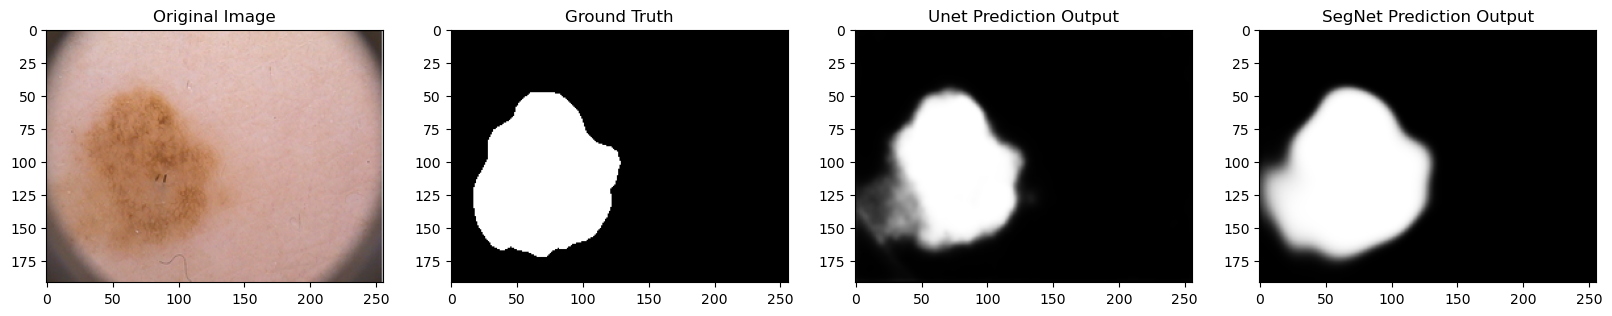

In [48]:
img_num = 1085
img_pred1 = unet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
img_pred2 = segnet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test_full[img_num])
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(y_test_full[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet Prediction Output')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet Prediction Output')
plt.show()

1/1 [==============================] - 0s 48ms/step


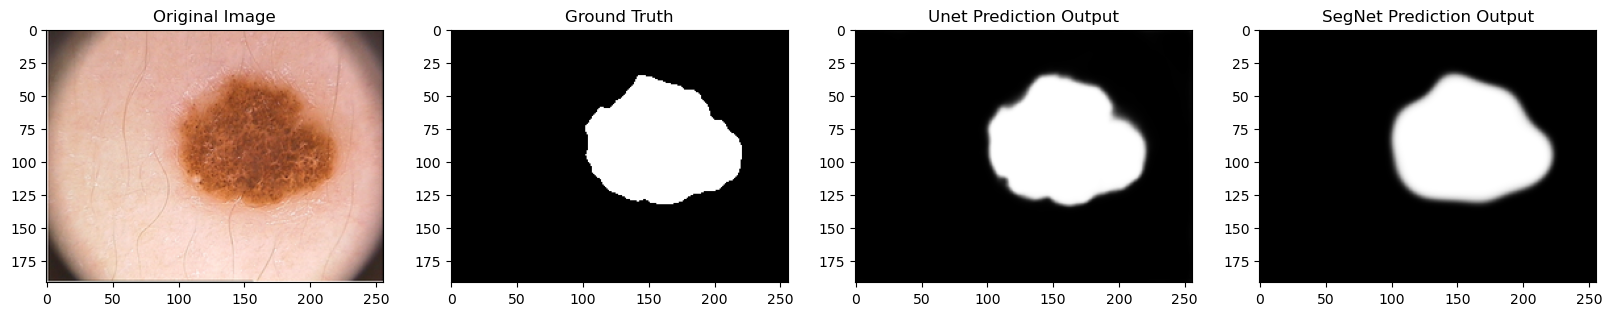

In [51]:
img_num = 999
img_pred1 = unet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
img_pred2 = segnet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test_full[img_num])
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(y_test_full[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet Prediction Output')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet Prediction Output')
plt.show()

# Bagging

In [45]:
def ensemble_model(img):
    sub1 = (unet_model.predict(img.reshape(1,192,256,3))).flatten()
    sub2 = (segnet_model.predict(img.reshape(1,192,256,3))).flatten()
    sub = sub1[:]
    for i in range(len(sub)):
        sub[i] = (sub1[i] + sub2[i])/2
        
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0

    return sub

1/1 [==============================] - 0s 37ms/step


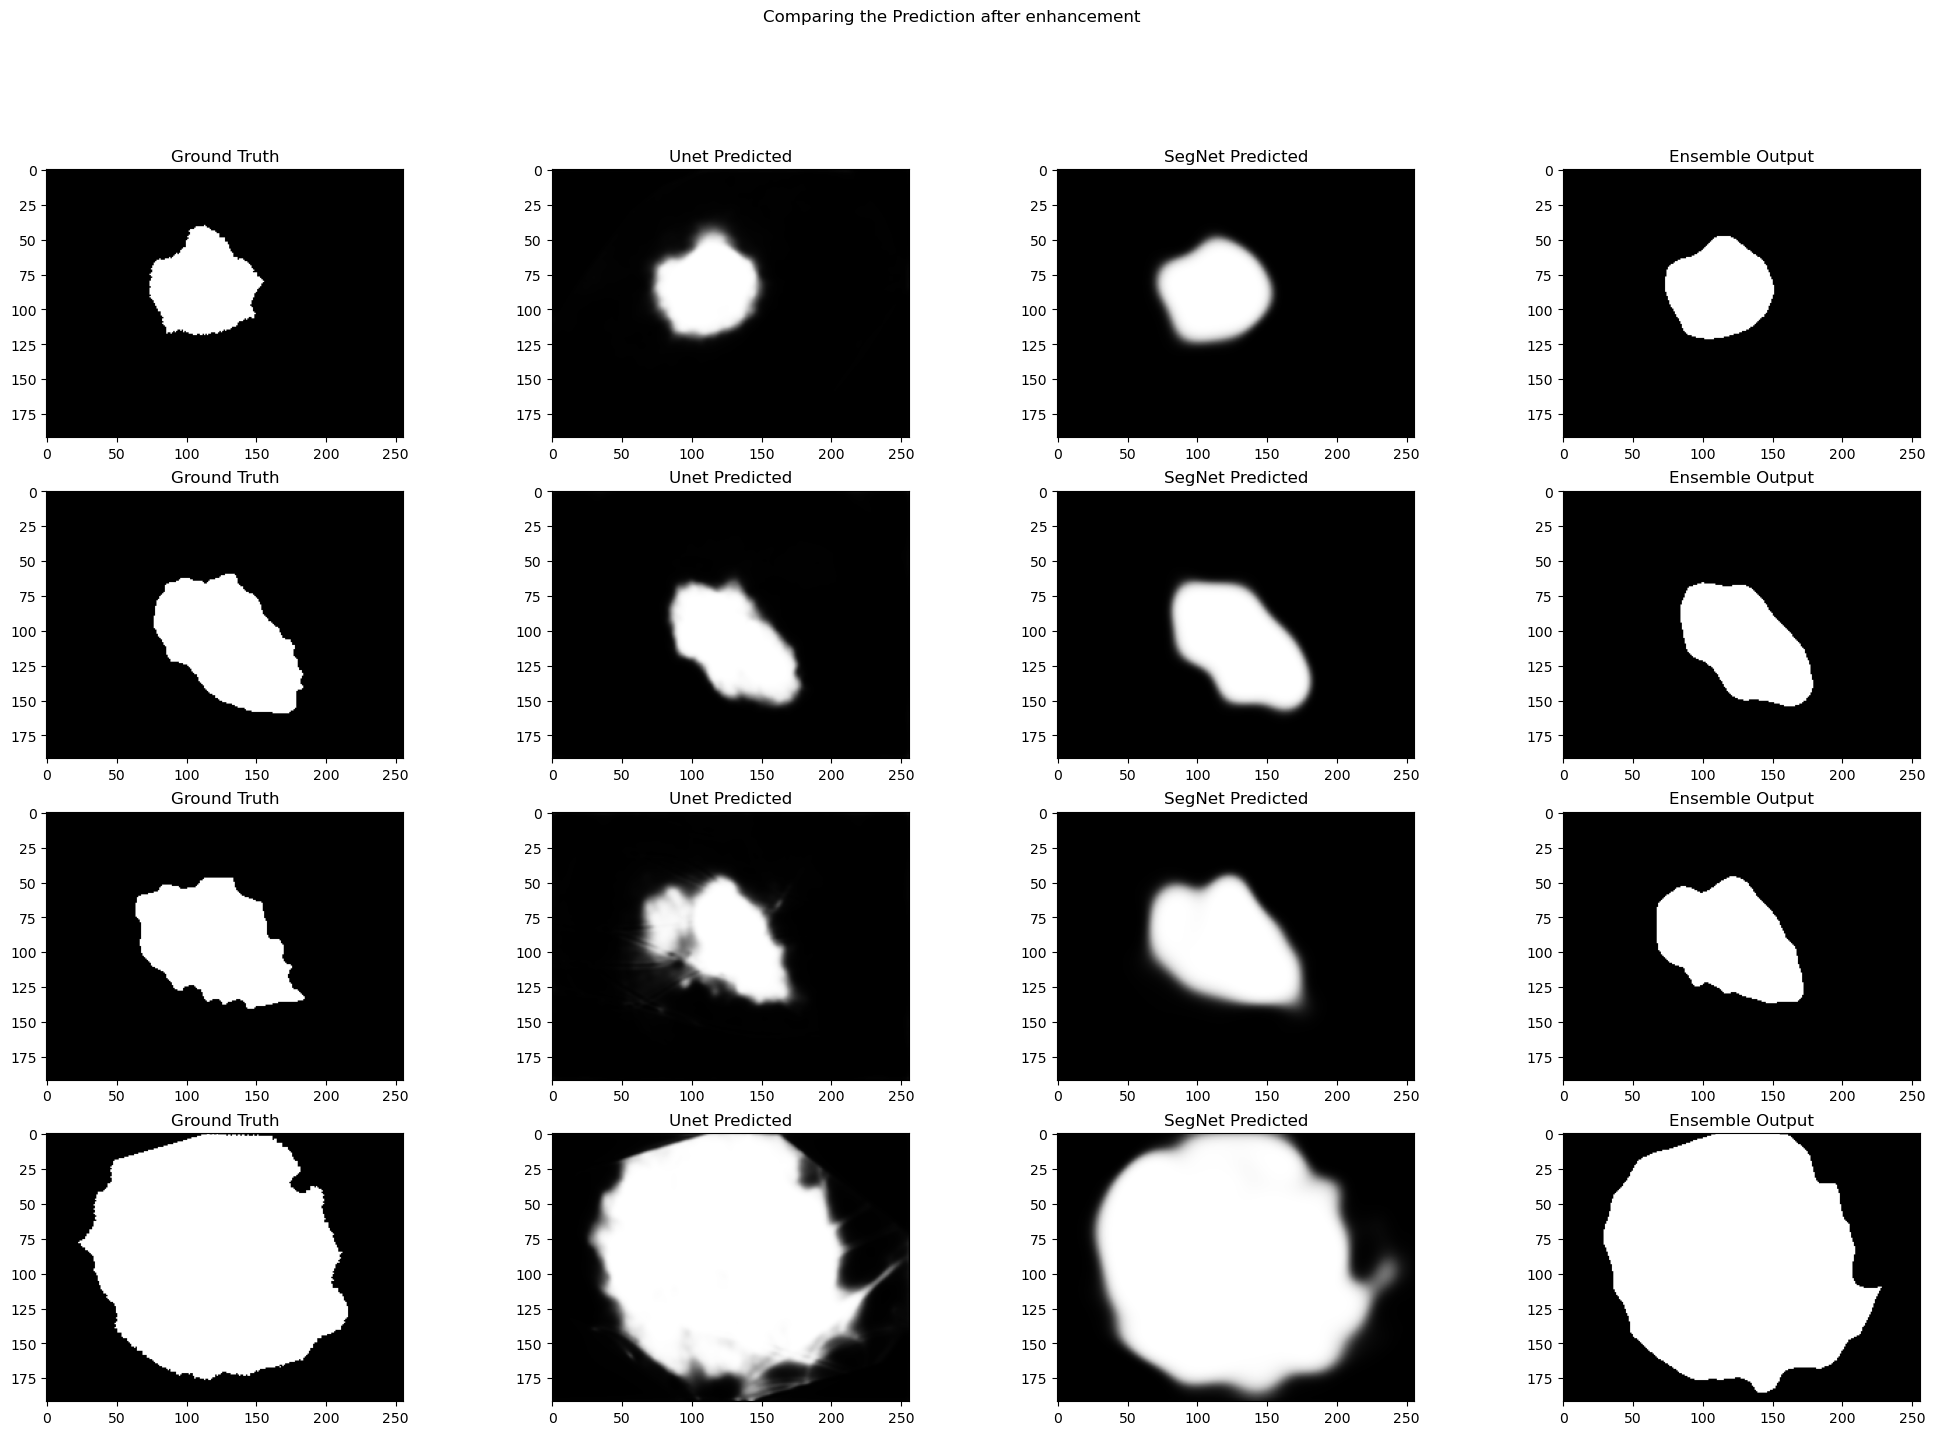

In [46]:
plt.figure(figsize=(25,16))
plt.suptitle('Comparing the Prediction after enhancement')

img_num = 48
plt.subplot(4,4,1)
plt.imshow(y_test_full[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,2)

img_pred1 = unet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
img_pred2 = segnet_model.predict(x_test_full[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,3)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,4)
plt.imshow(ensemble_model(x_test_full[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')


img_num = 37
plt.subplot(4,4,5)
plt.imshow(y_test_full[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,6)

img_pred1 = unet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
img_pred2 = segnet_model.predict(x_test_full[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,7)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,8)
plt.imshow(ensemble_model(x_test_full[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')

img_num = 11
plt.subplot(4,4,9)
plt.imshow(y_test_full[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,10)

img_pred1 = unet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
img_pred2 = segnet_model.predict(x_test_full[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,11)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,12)
plt.imshow(ensemble_model(x_test_full[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')

img_num = 49
plt.subplot(4,4,13)
plt.imshow(y_test_full[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,14)

img_pred1 = unet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
img_pred2 = segnet_model.predict(x_test_full[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,15)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,16)
plt.imshow(ensemble_model(x_test_full[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')
plt.show()